In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import seaborn as sns

from netam import framework, models, experiment
from netam.common import parameter_count_of_model

In [2]:
data_path = "/Users/matsen/data/greiff-systems-oof_pcp_2023-11-30_MASKED.csv"
df = pd.read_csv(data_path, index_col=0)

df = df[df["parent"] != df["child"]]
# df = df.sample(3000)

In [3]:
train_sample_ids = ['hepb-vax_m4_plasma', 'no-vax_m2_plasma', 'np-hel-vax_m2_plasma', 'ova-vax_m4_plasma', 'np-hel-vax_m3_plasma', 'no-vax_m1_plasma', 'ova-vax_m2_plasma', 'hepb-vax_m3_plasma', 'ova-vax_m5_plasma', 'hepb-vax_m1_plasma', 'no-vax_m3_plasma', 'no-vax_m4_plasma', 'ova-vax_m3_plasma', 'np-hel-vax_m1_plasma', 'np-hel-vax_m5_plasma']
val_sample_ids = ['no-vax_m5_plasma', 'ova-vax_m1_plasma', 'hepb-vax_m2_plasma', 'np-hel-vax_m4_plasma']

train_df = df[df["sample_id"].isin(train_sample_ids)]
val_df = df[df["sample_id"].isin(val_sample_ids)]

assert len(train_df) + len(val_df) == len(df)

In [4]:
expt = experiment.Experiment()

train_data_by_kmer_length = expt.data_by_kmer_length_of(train_df)
val_data_by_kmer_length = expt.data_by_kmer_length_of(val_df)

Using Metal Performance Shaders


In [8]:
training_params_by_model_name = {
    "mm_cnn_lrg": {"l2_regularization_coeff": 5e-7},
}

expt_df = expt.build_experiment_df("mm", train_data_by_kmer_length, val_data_by_kmer_length, training_params_by_model_name)

cnnpe_med = models.CNNPEModel(
                kmer_length=3,
                kernel_size=9,
                embedding_dim=8,
                filter_count=16,
                dropout_prob=0.2,
            )
cnnpe_row = {"model_name": "mm_cnnpe_med", "model": cnnpe_med, "parameter_count": parameter_count_of_model(cnnpe_med), "kmer_length": 3, "training_params": [{}], "train_dataset": train_data_by_kmer_length[3], "val_dataset": val_data_by_kmer_length[3]}

# add cnnpe_med to the experiment df
expt_df = pd.concat([expt_df, pd.DataFrame(cnnpe_row)], axis=0, ignore_index=True)

def view(expt_df):
    return expt_df.drop(columns=["model", "train_dataset", "val_dataset"])
    
view(expt_df)

,model_name,parameter_count,kmer_length,training_params
0,mm_cnn_sml,1007,3,{}
1,mm_cnn_med_orig,1495,3,{}
2,mm_cnn_med,1496,3,{}
3,mm_cnn_lrg,1957,3,{'l2_regularization_coeff': 5e-07}
4,mm_cnn_4k,3665,3,{}
5,mm_cnn_4k_k13,3941,3,{}
6,mm_cnn_8k,6211,3,{}
7,mm_fivemer,1025,5,{}
8,mm_shmoof,1525,5,{}
9,mm_cnnpe_med,1705,3,{}


In [9]:
expt.train_experiment_df(expt_df)

	Loading pre-trained mm_cnn_sml...
	Loading pre-trained mm_cnn_med_orig...
	Loading pre-trained mm_cnn_med...
	Loading pre-trained mm_cnn_lrg...
	Loading pre-trained mm_cnn_4k...
	Loading pre-trained mm_cnn_4k_k13...
	Loading pre-trained mm_cnn_8k...
	Loading pre-trained mm_fivemer...
	Loading pre-trained mm_shmoof...
	Training mm_cnnpe_med...


Epoch:   6%|▋         | 65/1000 [14:20<3:26:14, 13.23s/it, loss_diff=-1.715e-06, lr=3.2e-5, val_loss=0.03546] 


In [10]:
expt_df["val_loss"] = expt.loss_of_dataset_dict(expt_df, val_data_by_kmer_length)

view(expt_df)

,model_name,parameter_count,kmer_length,training_params,val_loss
0,mm_cnn_sml,1007,3,{},0.035199
1,mm_cnn_med_orig,1495,3,{},0.035080
2,mm_cnn_med,1496,3,{},0.035123
3,mm_cnn_lrg,1957,3,{'l2_regularization_coeff': 5e-07},0.035044
4,mm_cnn_4k,3665,3,{},0.034786
5,mm_cnn_4k_k13,3941,3,{},0.034848
6,mm_cnn_8k,6211,3,{},0.034703
7,mm_fivemer,1025,5,{},0.035666
8,mm_shmoof,1525,5,{},0.035095
9,mm_cnnpe_med,1705,3,{},0.035462


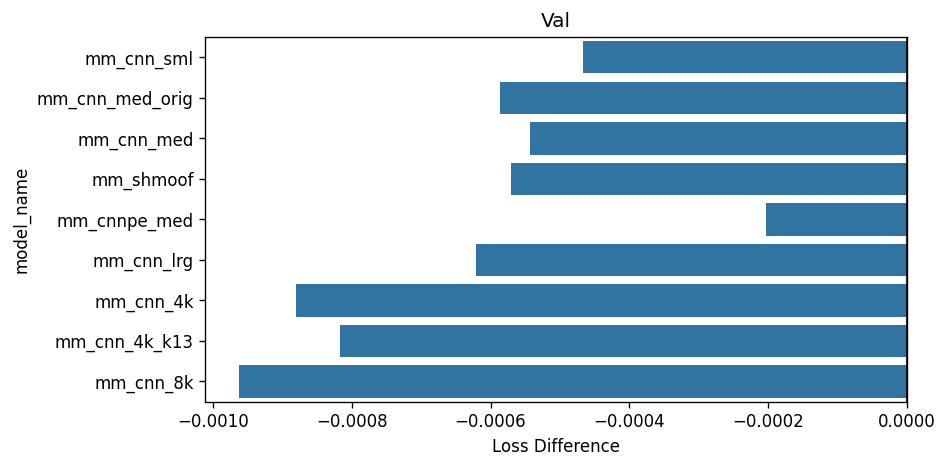

In [11]:
experiment.plot_loss_difference(expt_df, baseline_model_name='mm_fivemer')
